In [1]:

from os import listdir
from os.path import isfile, join
from typing import List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable
from robotpy_apriltag import AprilTagDetector

In [36]:
path = ".\\data\\apriltags_run2/0001SET/000"
images = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
len(images)

546

In [37]:
# Only use images with tags in them
images = images[(24 * 6):(74 * 6)]
len(images)

300

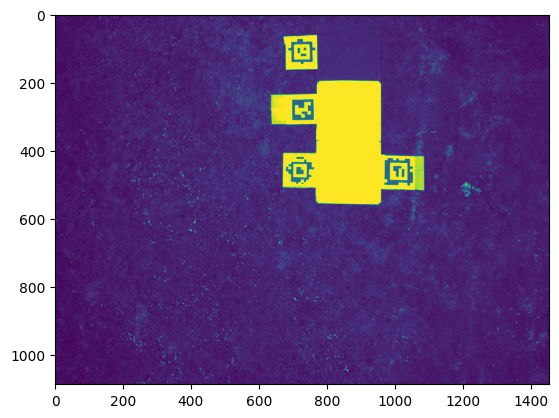

In [38]:
img = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img)

.\data\apriltags_run2/0001SET/000\IMG_0073_6.tif


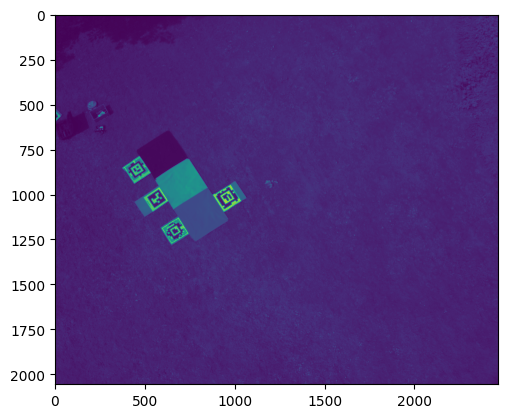

In [41]:
img = cv2.imread(images[-1], cv2.IMREAD_GRAYSCALE)
print(images[-1])
plt.imshow(img)

In [24]:
families = [
    "tagCircle21h7",
    "tagCircle49h12",
    "tag25h9",
]
detectors: List[AprilTagDetector] = []
config = AprilTagDetector.Config()
config.quadDecimate = 1.0
config.numThreads = 4
config.refineEdges = 1.0
for family in families:
    d = AprilTagDetector()
    d.addFamily(family)
    d.setConfig(config)
    detectors.append(d)

In [25]:
def verify_detection(tag) -> bool:
    valid_ids = [4]
    return tag.getId() in valid_ids


def filter_detections(tags):
    return [tag for tag in tags if verify_detection(tag)]

In [42]:
def detect_tags(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    TAG_AMOUNT = 1  # Assuming there is the same number of tags for each family
    return [(path, len(filter_detections(detector.detect(img))) - TAG_AMOUNT) for detector in detectors]

In [43]:
tag_amounts = [detect_tags(img) for img in images]

In [28]:
def as_percent_strings(values, total):
    as_percent = (values / total) * 100
    return list(map(lambda score: f"{'{0:.3g}'.format(score)}%", as_percent))

In [62]:
def get_results(amounts_per_image):
    correct = np.zeros(np.array(families).shape)
    false_positives = np.zeros(np.array(families).shape, )
    false_negatives = np.zeros(np.array(families).shape, )
    for amounts in amounts_per_image:
        for family_index, (path, amount) in enumerate(amounts):
            if amount == 0:
                correct[family_index] += 1
            if amount < 0:
                false_negatives[family_index] += 1
                print(families[family_index], path)
            if amount > 0:
                false_positives[family_index] += 1
    return list(zip(families,
                    as_percent_strings(correct, len(images)),
                    as_percent_strings(false_negatives, len(images)),
                    as_percent_strings(false_positives, len(images))))

In [64]:
results = get_results(tag_amounts)

tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0024_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0025_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0028_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0029_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0042_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0043_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0043_3.tif
tagCircle21h7 .\data\apriltags_run2/0001SET/000\IMG_0044_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0044_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0044_3.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0045_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0045_3.tif
tagCircle21h7 .\data\apriltags_run2/0001SET/000\IMG_0046_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0046_1.tif
tagCircle49h12 .\data\apriltags_run2/0001SET/000\IMG_0046_3.tif
tagCircle21h7 .\data\apriltags_run2/0001SE

In [57]:
result_table = PrettyTable(["Family Name", "Correct Identifications", "Too few detection", "Too Many Detections"])
result_table.add_rows(results)
result_table

Family Name,Correct Identifications,Too few detection,Too Many Detections
tagCircle21h7,85.7%,13.3%,1%
tagCircle49h12,78%,22%,0%
tag25h9,94.3%,5.67%,0%
